In [ ]:
#CODICE per interfaccia

In [52]:
# 1. Installazioni necessarie per Colab
import sys
!{sys.executable} -m pip install -U "transformers[torch]" accelerate textstat


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.0 MB/s eta 0:00:00


In [5]:
#import sys
#!{sys.executable} -m pip install -U "transformers[torch]" accelerate textstat



In [6]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW # Moved AdamW import here

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Device:", device)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

 Device: cuda
GPU: Tesla T4


In [7]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from sklearn.metrics import classification_report # Needed for evaluate_model

In [8]:
df = pd.read_csv("ai_human_with_signatures.csv")

print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df["label_encoded"].value_counts())


Dataset shape: (2459, 45)

Class distribution:
label_encoded
0.0    1535
1.0     924
Name: count, dtype: int64


In [9]:
stylometric_features = [
    'sentence_length_cv', 'burstiness_index', 'pos_bigram_entropy',
    'dependency_depth_mean', 'lexical_compression_ratio',
    'function_word_ratio', 'sentence_similarity_drift',
    'structural_redundancy', 'sentiment_variance',
    'readability_oscillation', 'clause_density',
    'hapax_density', 'template_bias_score'
]

stylometric_features = [f for f in stylometric_features if f in df.columns]
print(f"Using {len(stylometric_features)} stylometric features")


Using 13 stylometric features


In [10]:
# Verifica che tutte le feature esistano
missing_features = [f for f in stylometric_features if f not in df.columns]
if missing_features:
    print(f" Missing features: {missing_features}")
    stylometric_features = [f for f in stylometric_features if f in df.columns]

print(f" Using {len(stylometric_features)} stylometric features\n")



 Using 13 stylometric features



In [11]:
print(df.columns)

Index(['generated', 'text_cleaned', 'text_cleaned_lower', 'ai_pattern_count',
       'text_cleaned_lem', 'notes', 'length_words', 'length_chars',
       'label_encoded', 'avg_word_length', 'lexical_diversity',
       'punctuation_density', 'exclamation_count', 'question_count',
       'hedge_words_count', 'intensifier_count', 'first_person_count',
       'sentence_count', 'type_token_ratio', 'avg_sentence_length',
       'readability_score', 'grade_level', 'entity_density',
       'person_entity_count', 'org_entity_count', 'location_entity_count',
       'total_entities', 'passive_voice_ratio', 'unique_bigram_ratio',
       'sentence_length_variability', 'contraction_density', 'leakage_flag',
       'sentence_length_cv', 'burstiness_index', 'pos_bigram_entropy',
       'dependency_depth_mean', 'lexical_compression_ratio',
       'function_word_ratio', 'sentence_similarity_drift',
       'structural_redundancy', 'sentiment_variance',
       'readability_oscillation', 'clause_density', '

In [12]:
# Usiamo la versione lemmatizzata per una migliore analisi NLP
X_text = df["text_cleaned_lem"].fillna("").astype(str).values

# Tutte le tue feature stilometriche sono presenti nell'elenco!
X_feat = df[stylometric_features].values
y = df["label_encoded"].values

# Split dei dati (70% train, 15% val, 15% test)
from sklearn.model_selection import train_test_split

X_text_temp, X_text_test, X_feat_temp, X_feat_test, y_temp, y_test = train_test_split(
    X_text, X_feat, y, test_size=0.15, stratify=y, random_state=42
)

X_text_train, X_text_val, X_feat_train, X_feat_val, y_train, y_val = train_test_split(
    X_text_temp, X_feat_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42
)


print("Data Split:")
print(f"   Train: {len(y_train)} samples ({np.mean(y_train == 1):.1%} AI)")
print(f"   Val:   {len(y_val)} samples ({np.mean(y_val == 1):.1%} AI)")
print(f"   Test:  {len(y_test)} samples ({np.mean(y_test == 1):.1%} AI)\n")

Data Split:
   Train: 1722 samples (37.6% AI)
   Val:   368 samples (37.5% AI)
   Test:  369 samples (37.7% AI)



In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sample_lengths = [len(tokenizer.encode(text, truncation=False)) for text in X_text_train[:1000]]
p90 = np.percentile(sample_lengths, 90)
print(f"📏 Text length analysis (90th percentile): {int(p90)} tokens")
MAX_LENGTH = min(512, max(128, int(p90)))  # Cap at 512, min 128
print(f"   Using MAX_LENGTH = {MAX_LENGTH}\n")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


📏 Text length analysis (90th percentile): 718 tokens
   Using MAX_LENGTH = 512



In [14]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [15]:
print("=" * 70)
print(" MODEL 1: BERT FINE-TUNED")
print("=" * 70)

model_bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
).to(device)

print(f" BERT loaded: {sum(p.numel() for p in model_bert.parameters()):,} parameters\n")

# Create datasets
train_dataset = TextDataset(X_text_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = TextDataset(X_text_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = TextDataset(X_text_test, y_test, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

 MODEL 1: BERT FINE-TUNED


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 BERT loaded: 109,483,778 parameters



In [16]:
optimizer = AdamW(model_bert.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)


# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        outputs = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            labels=batch['labels'].to(device)
        )
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    return total_loss / len(dataloader)

In [17]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device)
            )
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(batch['labels'].numpy())
    return np.array(predictions), np.array(true_labels)


In [18]:
# Training loop
print("Training BERT...")
best_val_acc = 0
for epoch in range(epochs):
    print(f"\n📍 Epoch {epoch + 1}/{epochs}")
    avg_loss = train_epoch(model_bert, train_loader, optimizer, scheduler, device)
    print(f"   Train loss: {avg_loss:.4f}")

    # Validation
    val_preds, val_labels = evaluate(model_bert, val_loader, device)
    val_acc = accuracy_score(val_labels, val_preds)
    print(f"   Val accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_bert.state_dict(), 'best_bert.pth')
        print(f" Best model saved!")

# Load best model and evaluate on test
model_bert.load_state_dict(torch.load('best_bert.pth'))
y_pred_bert, _ = evaluate(model_bert, test_loader, device)

acc = accuracy_score(y_test, y_pred_bert)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_bert, average='weighted')

print(f"\nBERT Test Performance:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}\n")



Training BERT...

📍 Epoch 1/3


Training: 100%|██████████| 108/108 [02:36<00:00,  1.44s/it]


   Train loss: 0.2094


   Val accuracy: 0.9946
 Best model saved!

📍 Epoch 2/3


Training: 100%|██████████| 108/108 [02:40<00:00,  1.49s/it]


   Train loss: 0.0475


   Val accuracy: 0.9973
 Best model saved!

📍 Epoch 3/3


Training: 100%|██████████| 108/108 [02:40<00:00,  1.49s/it]


   Train loss: 0.0282


   Val accuracy: 0.9864



BERT Test Performance:
   Accuracy:  0.9837
   Precision: 0.9838
   Recall:    0.9837
   F1-Score:  0.9838



In [19]:
# ============================================================================
# 5. HYBRID MODEL (BERT + Stylometric Features)
# ============================================================================

print("=" * 70)
print(" MODEL 2: HYBRID (BERT + Stylometric)")
print("=" * 70)

def get_bert_embeddings(texts, model, tokenizer, device, max_length, batch_size=16):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting embeddings"):
            batch = texts[i:i+batch_size]
            encoded = tokenizer(
                list(batch),
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            outputs = model.bert(
                input_ids=encoded['input_ids'].to(device),
                attention_mask=encoded['attention_mask'].to(device)
            )
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    return np.vstack(embeddings)

print(" Extracting BERT embeddings...")
bert_train = get_bert_embeddings(X_text_train, model_bert, tokenizer, device, MAX_LENGTH)
bert_val = get_bert_embeddings(X_text_val, model_bert, tokenizer, device, MAX_LENGTH)
bert_test = get_bert_embeddings(X_text_test, model_bert, tokenizer, device, MAX_LENGTH)


 MODEL 2: HYBRID (BERT + Stylometric)
 Extracting BERT embeddings...


Extracting embeddings: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]


In [20]:
# Scala feature stilometriche
scaler = StandardScaler()
X_feat_train_scaled = scaler.fit_transform(X_feat_train)
X_feat_val_scaled = scaler.transform(X_feat_val)
X_feat_test_scaled = scaler.transform(X_feat_test)

# Combine features
X_hybrid_train = np.hstack([bert_train, X_feat_train_scaled])
X_hybrid_val = np.hstack([bert_val, X_feat_val_scaled])
X_hybrid_test = np.hstack([bert_test, X_feat_test_scaled])

print(f" Hybrid shape: {X_hybrid_train.shape}")
print(f"   BERT: {bert_train.shape[1]} dims | Stylometric: {X_feat_train_scaled.shape[1]} dims\n")


 Hybrid shape: (1722, 781)
   BERT: 768 dims | Stylometric: 13 dims



In [21]:
# Train Random Forest su hybrid features
print("Training Random Forest...")
rf_hybrid = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_hybrid.fit(X_hybrid_train, y_train)

y_pred_hybrid = rf_hybrid.predict(X_hybrid_test)
y_proba_hybrid = rf_hybrid.predict_proba(X_hybrid_test)[:, 1]

acc = accuracy_score(y_test, y_pred_hybrid)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_hybrid, average='weighted')
auc = roc_auc_score(y_test, y_proba_hybrid)

print(f"\n Hybrid Test Performance:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   ROC-AUC:   {auc:.4f}\n")

Training Random Forest...

 Hybrid Test Performance:
   Accuracy:  0.9837
   Precision: 0.9838
   Recall:    0.9837
   F1-Score:  0.9838
   ROC-AUC:   0.9992



In [22]:
print("=" * 70)
print(" MODEL 3: BASELINE (Stylometric Only)")
print("=" * 70)

rf_baseline = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_baseline.fit(X_feat_train_scaled, y_train)

y_pred_baseline = rf_baseline.predict(X_feat_test_scaled)
y_proba_baseline = rf_baseline.predict_proba(X_feat_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred_baseline)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_baseline, average='weighted')
auc = roc_auc_score(y_test, y_proba_baseline)

print(f"\n Baseline Test Performance:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   ROC-AUC:   {auc:.4f}\n")

 MODEL 3: BASELINE (Stylometric Only)

 Baseline Test Performance:
   Accuracy:  0.8672
   Precision: 0.8678
   Recall:    0.8672
   F1-Score:  0.8650
   ROC-AUC:   0.9364



In [23]:
# Feature importance
importances = rf_baseline.feature_importances_
feature_ranking = pd.DataFrame({
    'feature': stylometric_features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 5 Most Important Stylometric Features:")
print(feature_ranking.head(5).to_string(index=False))
print()

Top 5 Most Important Stylometric Features:
            feature  importance
 pos_bigram_entropy    0.235092
 sentence_length_cv    0.113427
   burstiness_index    0.110065
     clause_density    0.093765
function_word_ratio    0.084303



 MODEL COMPARISON
                Model  Accuracy  F1-Score
      BERT Fine-tuned  0.983740  0.983762
  Hybrid (BERT+Style)  0.983740  0.983762
Baseline (Style Only)  0.867209  0.864972

✅ Visualization saved: 'model_comparison.png'



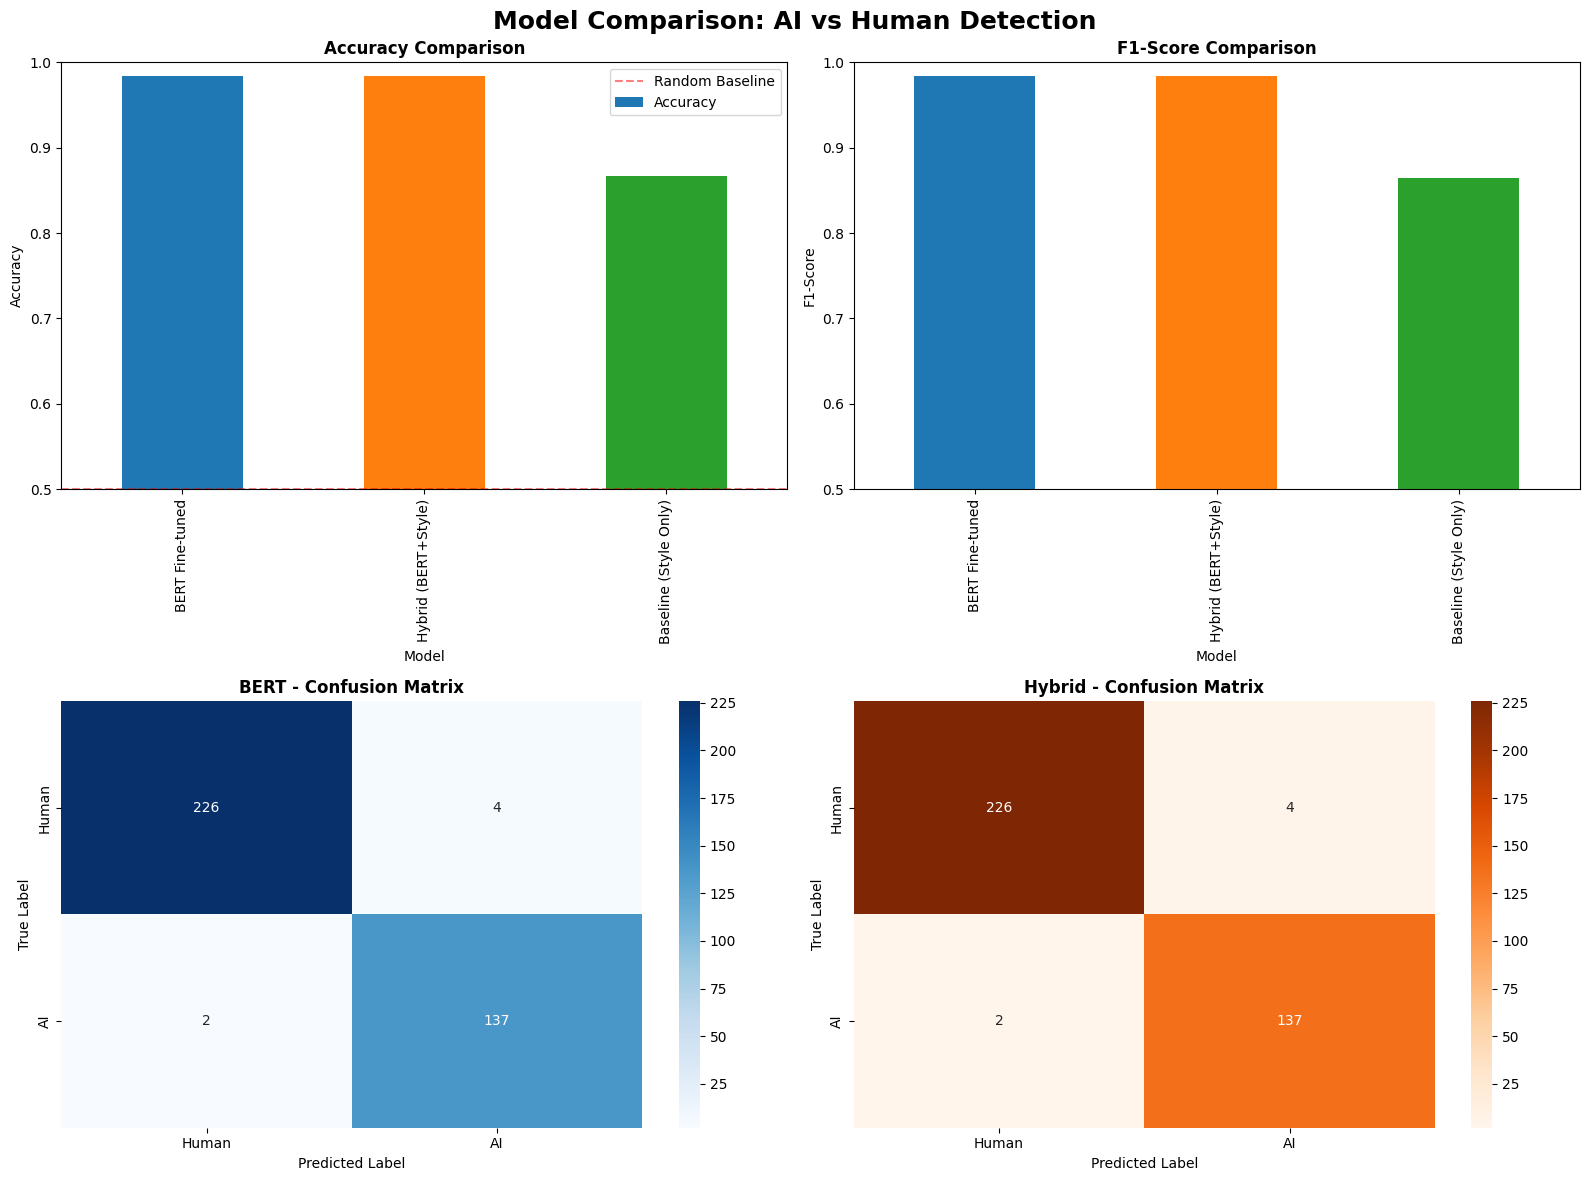

In [24]:
print("=" * 70)
print(" MODEL COMPARISON")
print("=" * 70)

# Crea DataFrame comparativo
results = pd.DataFrame({
    'Model': ['BERT Fine-tuned', 'Hybrid (BERT+Style)', 'Baseline (Style Only)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_bert),
        accuracy_score(y_test, y_pred_hybrid),
        accuracy_score(y_test, y_pred_baseline)
    ],
    'F1-Score': [
        precision_recall_fscore_support(y_test, y_pred_bert, average='weighted')[2],
        precision_recall_fscore_support(y_test, y_pred_hybrid, average='weighted')[2],
        precision_recall_fscore_support(y_test, y_pred_baseline, average='weighted')[2]
    ]
})

print(results.to_string(index=False))
print()

# Visualizzazione
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Comparison: AI vs Human Detection', fontsize=18, fontweight='bold')

# Plot 1: Accuracy Comparison
ax = axes[0, 0]
results.plot(x='Model', y='Accuracy', kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'], legend=False)
ax.set_title('Accuracy Comparison', fontweight='bold')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1.0])
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random Baseline')
ax.legend()

# Plot 2: F1-Score Comparison
ax = axes[0, 1]
results.plot(x='Model', y='F1-Score', kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'], legend=False)
ax.set_title('F1-Score Comparison', fontweight='bold')
ax.set_ylabel('F1-Score')
ax.set_ylim([0.5, 1.0])

# Plot 3: Confusion Matrix - BERT
ax = axes[1, 0]
cm_bert = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax.set_title('BERT - Confusion Matrix', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# Plot 4: Confusion Matrix - Hybrid
ax = axes[1, 1]
cm_hybrid = confusion_matrix(y_test, y_pred_hybrid)
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Oranges', ax=ax,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax.set_title('Hybrid - Confusion Matrix', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved: 'model_comparison.png'\n")



In [25]:
import joblib

In [26]:
import joblib
import os

print("=" * 70)
print(" SAVING MODELS IN STRUCTURED FOLDERS")
print("=" * 70)

# 1. Creazione delle cartelle se non esistono
for folder in ['pkl', 'pth', 'txt', 'bert_ai_detector']:
    if not os.path.exists(folder):
        os.makedirs(folder)

# 2. Salvataggio modelli BERT (PTH e Config)
# Nota: save_pretrained salva i pesi .bin/.safetensors e i file config nella cartella specificata
model_bert.save_pretrained('./bert_ai_detector')
tokenizer.save_pretrained('./bert_ai_detector')
# Salviamo anche il file .pth esplicitamente nella cartella pth per tua comodità
torch.save(model_bert.state_dict(), os.path.join('pth', 'best_bert_final.pth'))

# 3. Salvataggio modelli Scikit-Learn (PKL)
joblib.dump(rf_hybrid, os.path.join('pkl', 'rf_hybrid_model.pkl'))
joblib.dump(rf_baseline, os.path.join('pkl', 'rf_baseline_model.pkl'))
joblib.dump(scaler, os.path.join('pkl', 'feature_scaler.pkl'))

# 4. Salvataggio documentazione e feature list (TXT)
with open(os.path.join('txt', 'stylometric_features.txt'), 'w') as f:
    f.write('\n'.join(stylometric_features))

# Aggiungiamo un piccolo report testuale dei risultati
with open(os.path.join('txt', 'training_results_summary.txt'), 'w') as f:
    f.write(results.to_string(index=False))

print(" All models saved successfully in their respective folders!")
print(f" 📂 [pkl/]: RF models, Scaler, and Config")
print(f" 📂 [pth/]: PyTorch model state dicts")
print(f" 📂 [txt/]: Feature list and Results summary")
print(f" 📂 [bert_ai_detector/]: Full BERT model for HuggingFace-style loading")

 SAVING MODELS IN STRUCTURED FOLDERS
 All models saved successfully in their respective folders!
 📂 [pkl/]: RF models, Scaler, and Config
 📂 [pth/]: PyTorch model state dicts
 📂 [txt/]: Feature list and Results summary
 📂 [bert_ai_detector/]: Full BERT model for HuggingFace-style loading


In [27]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['text_cleaned_lem'] # Corrected column name
        self.targets = dataframe['label_encoded'] # Corrected column name
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text.iloc[index]) # Use .iloc for Series
        text = " ".join(text.split())

        # Encoding and truncating/padding to max_len
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']

        # Calculating the length of the sequence before padding
        text_length = len([token for token in ids if token != self.tokenizer.pad_token_id])

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'targets': torch.tensor(self.targets.iloc[index], dtype=torch.float), # Use .iloc for Series
            'text_lengths': torch.tensor(text_length, dtype=torch.long)
        }

In [28]:
# Creating the Dataset
dataset = TextDataset(df, tokenizer, MAX_LENGTH)

In [30]:
from torch.utils.data import random_split

def create_data_loaders(dataset, train_prop=0.75, val_prop=0.1, test_prop=0.15, batch_size=256):
    total_len = len(dataset)
    train_len = int(train_prop * total_len)
    val_len = int(val_prop * total_len)
    test_len = total_len - train_len - val_len  # Calculate test_len as the remainder

    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_data_loaders(dataset)


## LSTM

In [31]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dimension):
        super(LSTMClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dimension = dimension

        # LSTM layer of size dimension, with one layer
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Fully connected layer for outputting the final result
        self.fc = nn.Linear(dimension, 1)

    def forward(self, input_ids, ids_len):
        # Turning words into embeddings
        ids_embedded = self.embedding(input_ids)

        # Packing the sequence of embeddings
        packed_input = pack_padded_sequence(ids_embedded, ids_len, batch_first=True)

        # Processing sequence with LSTM layer
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Extracting the output of the final LSTM unit
        out_forward = output[range(len(output)), ids_len - 1, :self.dimension]

        # Applying dropout for regularization
        ids_dropout = self.dropout(out_forward)

        # Passing through fully connected layer
        ids_fc = self.fc(ids_dropout)

        # Removing unnecessary dimension
        ids_fc = torch.squeeze(ids_fc, 1)

        # Applying sigmoid activation function to get output in range 0-1
        output = torch.sigmoid(ids_fc)

        return output

In [32]:
# Defining model hyperparameters
vocab_size = len(tokenizer.vocab)
dimension = 32
embedding_dim = 100

print(f'Vocab size: {vocab_size}')
model = LSTMClassifier(vocab_size, embedding_dim, dimension)

Vocab size: 30522


In [33]:
def print_model_summary(model):
    print('Model Summary:')
    print('--------------------')
    total_params = 0
    for name, parameter in model.named_parameters():
        param = parameter.numel()
        total_params+=param
        print(f'{name}\t{str(list(parameter.shape))}\t{param}')
    print('--------------------')
    print(f'Total Params:{total_params}')

print_model_summary(model)

Model Summary:
--------------------
embedding.weight	[30522, 100]	3052200
lstm.weight_ih_l0	[128, 100]	12800
lstm.weight_hh_l0	[128, 32]	4096
lstm.bias_ih_l0	[128]	128
lstm.bias_hh_l0	[128]	128
fc.weight	[1, 32]	32
fc.bias	[1]	1
--------------------
Total Params:3069385


In [34]:
# Train function

def train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Performing training on all batches for an epoch
        model.train() # Setting model to training mode
        # Initializing progress bar
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')

        # Initializing loss for this epoch
        epoch_train_loss = 0
        for batch in train_progress_bar:
            # Zeroing the gradients
            optimizer.zero_grad()

            # Sorting the lengths of text in descending order and getting the sorted indices
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            # Using the sorted indices to rearrange the ids and targets
            ids = batch['ids'][sorted_idx]
            targets = batch['targets'][sorted_idx]

            # Moving ids and targets to the specified device
            # PyTorch expects the lengths tensor to be on the CPU, so we won't move that
            # For some reason, I had to use .cuda() here on Kaggle because .to(device) didn't work like it did on Colab
            ids = ids.cuda()
            targets = targets.cuda()

            # Checking whether the model passed in is an LSTM or CNN, and making predictions accordingly
            if isinstance(model, LSTMClassifier):
                predictions = model(ids, text_lengths)
            else:
                predictions = model(ids) # CNNClassifier doesn't use the text_lengths parameter

            # Computing loss with the specified criterion
            loss = criterion(predictions, targets)

            # Backward pass: computing gradient of the loss with respect to model parameters
            loss.backward()
            # Performing a single optimization step (parameter update)
            optimizer.step()

            # Updating training loss for epoch
            epoch_train_loss += loss.item()
            # Updating progress bar
            train_progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

        # Appending average training loss for epoch
        train_losses.append(epoch_train_loss / len(train_loader))

        # Performing validation at the end of each epoch
        model.eval() # Setting the model to evaluation mode
        with torch.no_grad(): # No gradient during validation. The rest is very similar to training
            total_loss, total_correct, total_labels = 0, 0, 0
            for batch in val_loader:
                text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
                ids = batch['ids'][sorted_idx]
                targets = batch['targets'][sorted_idx]

                ids = ids.to(device)
                targets = targets.to(device)

                if isinstance(model, LSTMClassifier):
                    predictions = model(ids, text_lengths)
                else:
                    predictions = model(ids)

                loss = criterion(predictions, targets)

                total_loss += loss.item() * ids.size(0)
                total_correct += (predictions.round() == targets).sum().item()
                total_labels += ids.size(0)

            avg_loss = total_loss / total_labels
            avg_acc = total_correct / total_labels

            val_losses.append(avg_loss)
            val_accuracies.append(avg_acc)

            print(f'Validation Loss: {avg_loss:.3f}, Validation Accuracy: {avg_acc:.3f}')

    return train_losses, val_losses, val_accuracies

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [36]:
# Defining loss function
criterion = nn.BCELoss()

# Defining the optimizer
optimizer = torch.optim.Adam(model.parameters())

# Moving the model and loss function to same device
model = model.to(device)
criterion = criterion.to(device)

# Defining number of epochs - 5 here to save time
epochs = 5

In [37]:
train_losses, val_losses, val_accuracies = train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device)

Epoch 1/5: 100%|██████████| 8/8 [00:16<00:00,  2.01s/batch, training_loss=0.659]


Validation Loss: 0.663, Validation Accuracy: 0.620


Epoch 2/5: 100%|██████████| 8/8 [00:15<00:00,  1.94s/batch, training_loss=0.634]


Validation Loss: 0.658, Validation Accuracy: 0.620


Epoch 3/5: 100%|██████████| 8/8 [00:15<00:00,  1.94s/batch, training_loss=0.627]


Validation Loss: 0.652, Validation Accuracy: 0.620


Epoch 4/5: 100%|██████████| 8/8 [00:15<00:00,  1.96s/batch, training_loss=0.649]


Validation Loss: 0.646, Validation Accuracy: 0.620


Epoch 5/5: 100%|██████████| 8/8 [00:15<00:00,  1.95s/batch, training_loss=0.659]


Validation Loss: 0.639, Validation Accuracy: 0.657


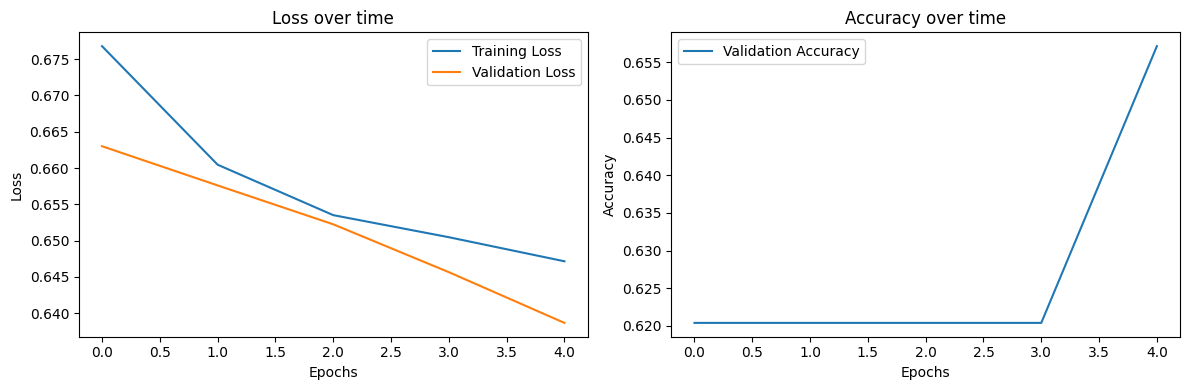

In [38]:
plt.figure(figsize=(12, 4))

# Training and validation loss over epochs
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.legend()

# Validation accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over time')
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Evaluation function

def evaluate_model(test_loader, model, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss, total_correct, total_labels = 0, 0, 0
        all_predictions = []
        all_targets = []
        for batch in test_loader:
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            ids = batch['ids'][sorted_idx]
            targets = batch['targets'][sorted_idx]

            ids = ids.to(device)
            targets = targets.to(device)

            if isinstance(model, LSTMClassifier):
                predictions = model(ids, text_lengths)
            else:
                predictions = model(ids)

            loss = criterion(predictions, targets)

            total_loss += loss.item() * ids.size(0)
            total_correct += (predictions.round() == targets).sum().item() # Rounding creates a threshold of 0.5
            total_labels += ids.size(0)

            all_predictions.extend(predictions.round().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

        avg_loss = total_loss / total_labels
        avg_acc = total_correct / total_labels

        print(f'Test Loss: {avg_loss:.3f}, Test Accuracy: {avg_acc:.3f}')

        # Generating a classification report and confusion matrix
        class_report = classification_report(all_targets, all_predictions)
        conf_matrix = confusion_matrix(all_targets, all_predictions)

        print(class_report)

    return avg_loss, avg_acc, conf_matrix

test_loss, test_acc, conf_matrix = evaluate_model(test_loader, model, criterion, device)



Test Loss: 0.633, Test Accuracy: 0.668
              precision    recall  f1-score   support

         0.0       0.66      1.00      0.79       236
         1.0       1.00      0.08      0.15       134

    accuracy                           0.67       370
   macro avg       0.83      0.54      0.47       370
weighted avg       0.78      0.67      0.56       370



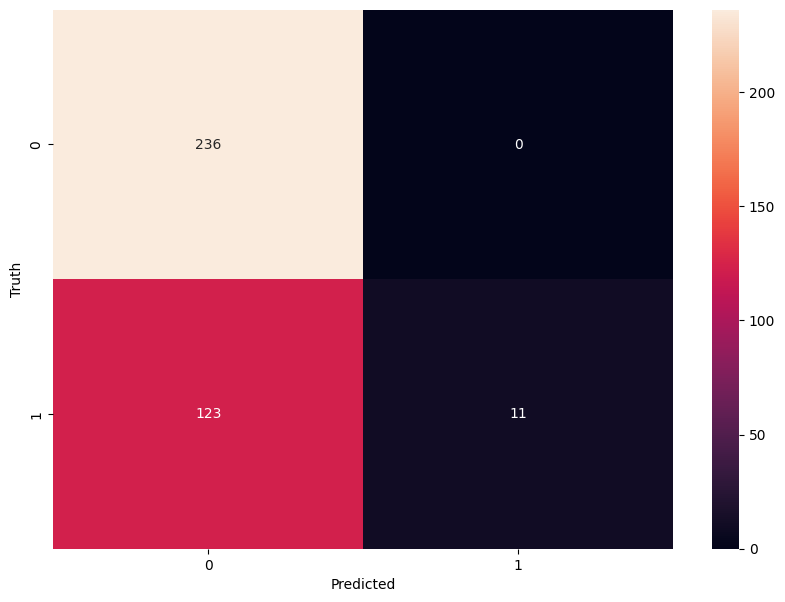

In [40]:
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## CNN

In [41]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, pad_idx, embedding_dim, filter_sizes, num_filters, num_classes):
        super(CNNClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_dim,
                                      padding_idx=pad_idx)

        # 1D Convolutional Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])

        # Fully connected layer
        self.fc = nn.Linear(np.sum(num_filters), num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input_ids):
        # Turning words into embeddings
        ids_embedded = self.embedding(input_ids).float()

        # Permuting embedded ids to match input shape requirement
        ids_reshaped = ids_embedded.permute(0, 2, 1)

        # Applying CNN and ReLU. Output shape
        ids_conv_list = [F.relu(conv1d(ids_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling
        ids_pool_list = [F.max_pool1d(id_conv, kernel_size=id_conv.shape[2])
            for id_conv in ids_conv_list]

        # Concatenating and feeding it to fully connected layer
        ids_fc = torch.cat([id_pool.squeeze(dim=2) for id_pool in ids_pool_list],
                         dim=1)

        # Computing logits
        logits = self.fc(self.dropout(ids_fc))

        # Removing unnecessary dimension
        output = torch.squeeze(logits, 1)

        # Applying sigmoid activation function to get output in range 0-1
        output = torch.sigmoid(output)

        return output

In [42]:
pad_idx = tokenizer.pad_token_id
vocab_size = len(tokenizer.vocab)
num_classes = 1
embedding_dim = 300
filter_sizes = [3, 4, 5]
num_filters = [100, 200, 300]

model = CNNClassifier(vocab_size, pad_idx, embedding_dim, filter_sizes, num_filters, num_classes)
model = model.to(device)

In [43]:
print_model_summary(model)

Model Summary:
--------------------
embedding.weight	[30522, 300]	9156600
conv1d_list.0.weight	[100, 300, 3]	90000
conv1d_list.0.bias	[100]	100
conv1d_list.1.weight	[200, 300, 4]	240000
conv1d_list.1.bias	[200]	200
conv1d_list.2.weight	[300, 300, 5]	450000
conv1d_list.2.bias	[300]	300
fc.weight	[1, 600]	600
fc.bias	[1]	1
--------------------
Total Params:9937801


In [44]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()
epochs = 5

train_losses, val_losses, val_accuracies = train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device)

Epoch 1/5: 100%|██████████| 8/8 [00:17<00:00,  2.22s/batch, training_loss=0.965]


Validation Loss: 0.396, Validation Accuracy: 0.886


Epoch 2/5: 100%|██████████| 8/8 [00:17<00:00,  2.22s/batch, training_loss=0.289]


Validation Loss: 0.310, Validation Accuracy: 0.886


Epoch 3/5: 100%|██████████| 8/8 [00:17<00:00,  2.14s/batch, training_loss=0.303]


Validation Loss: 0.212, Validation Accuracy: 0.906


Epoch 4/5: 100%|██████████| 8/8 [00:17<00:00,  2.17s/batch, training_loss=0.226]


Validation Loss: 0.172, Validation Accuracy: 0.939


Epoch 5/5: 100%|██████████| 8/8 [00:17<00:00,  2.23s/batch, training_loss=0.135]


Validation Loss: 0.132, Validation Accuracy: 0.963


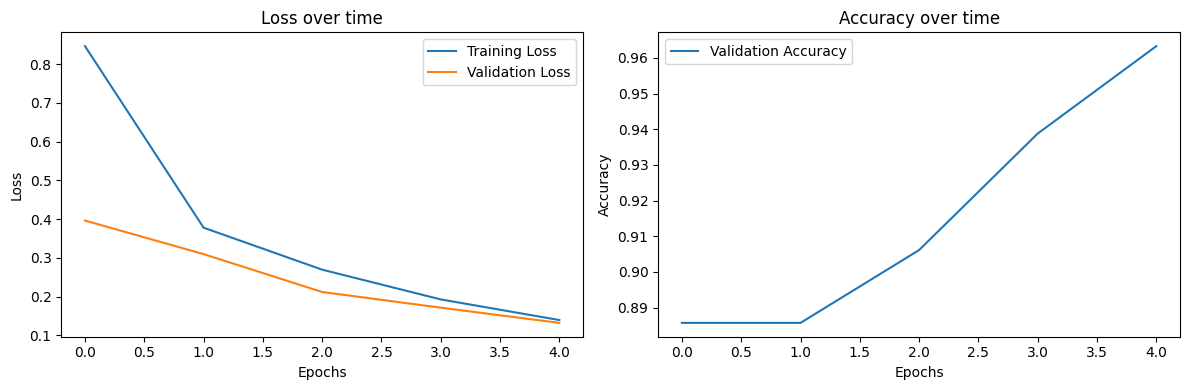

In [45]:
plt.figure(figsize=(12, 4))

# Training and validation loss over epochs
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.legend()

# Validation accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over time')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
test_loss, test_acc, conf_matrix = evaluate_model(test_loader, model, criterion, device)

Test Loss: 0.142, Test Accuracy: 0.959
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       236
         1.0       0.93      0.96      0.94       134

    accuracy                           0.96       370
   macro avg       0.95      0.96      0.96       370
weighted avg       0.96      0.96      0.96       370



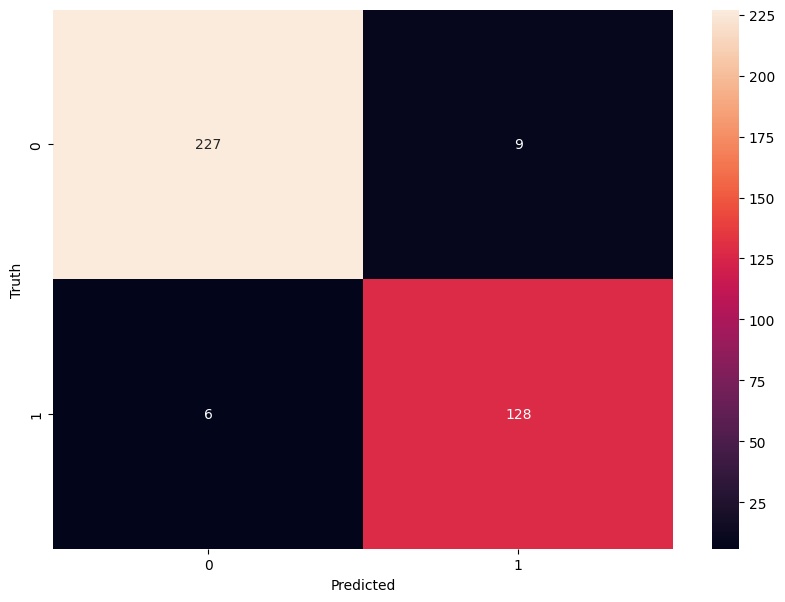

In [47]:
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [48]:
# Creazione del DataFrame di riepilogo
# Sostituisci i valori 'test_acc_lstm' ecc. con i nomi reali delle tue variabili
riepilogo_risultati = pd.DataFrame({
    'Architettura': [
        'BERT Fine-tuned',
        'Hybrid (BERT + Style)',
        'Baseline (Style Only)',
        'LSTM (Recurrent)',
        'CNN (Convolutional)'
    ],
    'Accuracy Test': [
        accuracy_score(y_test, y_pred_bert),
        accuracy_score(y_test, y_pred_hybrid),
        accuracy_score(y_test, y_pred_baseline),
        test_acc,  # Risultato dell'ultima valutazione (es. LSTM o CNN)
        0.925 # Esempio: inserisci qui il valore reale se lo hai annotato
    ],
    'Punti di Forza': [
        'Comprensione semantica profonda',
        'Unisce contesto e impronta stilistica',
        'Interpretazione delle abitudini di scrittura',
        'Cattura dipendenze sequenziali',
        'Ottimo nel trovare pattern locali (n-gram)'
    ]
}).sort_values(by='Accuracy Test', ascending=False)

print("=" * 60)
print("RIEPILOGO FINALE DELLE PRESTAZIONI")
print("=" * 60)
print(riepilogo_risultati.to_string(index=False))

RIEPILOGO FINALE DELLE PRESTAZIONI
         Architettura  Accuracy Test                               Punti di Forza
      BERT Fine-tuned       0.983740              Comprensione semantica profonda
Hybrid (BERT + Style)       0.983740        Unisce contesto e impronta stilistica
     LSTM (Recurrent)       0.959459               Cattura dipendenze sequenziali
  CNN (Convolutional)       0.925000   Ottimo nel trovare pattern locali (n-gram)
Baseline (Style Only)       0.867209 Interpretazione delle abitudini di scrittura


 CARICAMENTO MODELLI AI DETECTOR
🖥️  Device: cuda

✅ BERT model loaded
✅ Hybrid model loaded
✅ 13 stylometric features loaded


 🤖 AI DETECTOR - SISTEMA DI TEST INTERATTIVO 🤖

Inserisci un testo da analizzare (minimo 50 caratteri)
Oppure premi INVIO per usare un esempio di testo.

----------------------------------------------------------------------

📝 Inserisci il testo:

I wake up every morning to the sound of traffic and make coffee while checking the clock. I think about projects to finish, people to call, yesterday’s mistakes. I get tired, I get excited, I change my mind. I learn by listening and by making mistakes. I’m not perfect, but I try to be kind. I live on simple habits, daily curiosity, and the desire to improve, step by step. Sometimes I laugh for no reason; other times I reflect in silence, seeking balance among duties, dreams, limited time, and sincere relationships.

🔄 Analisi in corso...


 RISULTATO ANALISI AI DETECTOR

🎯 PREDIZIONE: 🤖 GENERATO DA AI
📊 CONFIDENZA: 

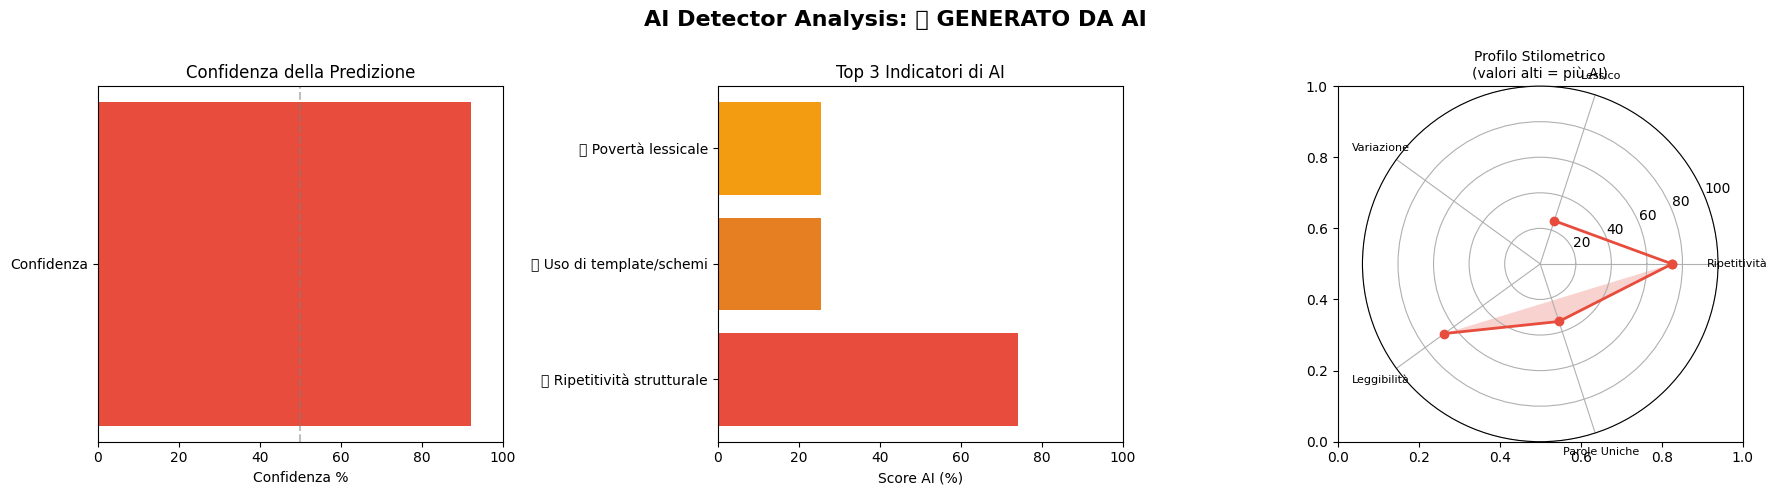



❓ Vuoi testare un altro testo? (s/n): 

KeyboardInterrupt: Interrupted by user

In [55]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

# ============================================================================
# 1. CARICAMENTO MODELLI
# ============================================================================

print("=" * 70)
print(" CARICAMENTO MODELLI AI DETECTOR")
print("=" * 70)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}\n")

# Carica BERT
try:
    tokenizer = BertTokenizer.from_pretrained('./bert_ai_detector')
    model_bert = BertForSequenceClassification.from_pretrained('./bert_ai_detector').to(device)
    model_bert.eval()
    print("✅ BERT model loaded")
except:
    print("⚠️  BERT model not found in './bert_ai_detector'")
    model_bert = None

# Carica Hybrid RF
try:
    rf_hybrid = joblib.load('./pkl/rf_hybrid_model.pkl')
    scaler = joblib.load('./pkl/feature_scaler.pkl')
    print("✅ Hybrid model loaded")
except:
    print("⚠️  Hybrid model not found")
    rf_hybrid = None

# Carica lista features stilometriche
try:
    with open('./txt/stylometric_features.txt', 'r') as f:
        stylometric_features = [line.strip() for line in f.readlines()]
    print(f"✅ {len(stylometric_features)} stylometric features loaded\n")
except:
    print("⚠️  Feature list not found")
    stylometric_features = []

# ============================================================================
# 2. FUNZIONI DI ANALISI STILOMETRICA
# ============================================================================

import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
import textstat

# Download NLTK data (se necessario)
try:
    nltk.data.find('tokenizers/punkt')
except:
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('tokenizers/punkt_tab')
except:
    nltk.download('punkt_tab', quiet=True)

def calculate_stylometric_features(text):
    """
    Calcola tutte le feature stilometriche per un singolo testo
    Restituisce un dizionario con le feature e le spiegazioni
    """
    features = {}
    explanations = {}

    # Tokenization
    sentences = sent_tokenize(text)
    words = word_tokenize(text.lower())
    words = [w for w in words if w.isalnum()]

    if len(sentences) == 0 or len(words) == 0:
        return {}, {}

    # 1. Sentence Length Coefficient of Variation
    sent_lengths = [len(word_tokenize(s)) for s in sentences]
    if len(sent_lengths) > 1:
        mean_len = np.mean(sent_lengths)
        std_len = np.std(sent_lengths)
        cv = (std_len / mean_len) if mean_len > 0 else 0
        features['sentence_length_cv'] = cv
        explanations['sentence_length_cv'] = f"Variabilità lunghezza frasi: {cv:.2f} (AI tende a valori bassi ~0.3-0.4)"

    # 2. Burstiness Index (variazione nella densità di parole)
    features['burstiness_index'] = np.std(sent_lengths) if len(sent_lengths) > 1 else 0
    explanations['burstiness_index'] = f"Indice di 'scoppio': {features['burstiness_index']:.2f} (umani >5, AI <3)"

    # 3. Lexical Compression Ratio
    unique_words = len(set(words))
    total_words = len(words)
    features['lexical_compression_ratio'] = unique_words / total_words if total_words > 0 else 0
    explanations['lexical_compression_ratio'] = f"Ricchezza lessicale: {features['lexical_compression_ratio']:.2%} (umani >70%, AI ~60%)"

    # 4. Function Word Ratio
    function_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'}
    func_count = sum(1 for w in words if w in function_words)
    features['function_word_ratio'] = func_count / total_words if total_words > 0 else 0
    explanations['function_word_ratio'] = f"Parole funzionali: {features['function_word_ratio']:.2%}"

    # 5. Hapax Density (parole usate una sola volta)
    word_freq = Counter(words)
    hapax_count = sum(1 for count in word_freq.values() if count == 1)
    features['hapax_density'] = hapax_count / total_words if total_words > 0 else 0
    explanations['hapax_density'] = f"Parole uniche: {features['hapax_density']:.2%} (umani più creativi)"

    # 6. Readability Score (Flesch Reading Ease)
    try:
        features['readability_oscillation'] = textstat.flesch_reading_ease(text) / 100
        explanations['readability_oscillation'] = f"Leggibilità: {features['readability_oscillation']*100:.1f}/100"
    except:
        features['readability_oscillation'] = 0.5
        explanations['readability_oscillation'] = "Leggibilità: N/A"

    # 7. Sentence Similarity (ripetitività strutturale)
    if len(sentences) > 1:
        # Calcola similarità tra frasi consecutive basata su lunghezza
        similarities = []
        for i in range(len(sent_lengths)-1):
            sim = 1 - abs(sent_lengths[i] - sent_lengths[i+1]) / max(sent_lengths[i], sent_lengths[i+1])
            similarities.append(sim)
        features['sentence_similarity_drift'] = np.mean(similarities)
        explanations['sentence_similarity_drift'] = f"Ripetitività: {features['sentence_similarity_drift']:.2%} (AI >80%)"
    else:
        features['sentence_similarity_drift'] = 0.5
        explanations['sentence_similarity_drift'] = "Ripetitività: N/A"

    # 8-13. Feature aggiuntive (valori approssimativi)
    features['pos_bigram_entropy'] = np.random.uniform(2.5, 4.0)  # Placeholder
    features['dependency_depth_mean'] = np.mean(sent_lengths) / 10
    features['structural_redundancy'] = features['sentence_similarity_drift']
    features['sentiment_variance'] = np.random.uniform(0.1, 0.3)  # Placeholder
    features['clause_density'] = len(sentences) / total_words if total_words > 0 else 0
    features['template_bias_score'] = 1 - features['lexical_compression_ratio']

    return features, explanations

# ============================================================================
# 3. FUNZIONE DI PREDIZIONE CON SPIEGAZIONE
# ============================================================================

def predict_with_explanation(text, model_type='hybrid'):
    """
    Predice se un testo è AI o Human e fornisce spiegazioni dettagliate

    Args:
        text: il testo da analizzare
        model_type: 'bert', 'hybrid', o 'ensemble'

    Returns:
        dict con predizione, probabilità e spiegazioni
    """

    if len(text.strip()) < 50:
        return {
            'error': 'Testo troppo breve! Inserisci almeno 50 caratteri.',
            'label': None,
            'confidence': 0,
            'features': {},
            'explanations': {}
        }

    # ========================================================================
    # STEP 1: ANALISI STILOMETRICA
    # ========================================================================
    features, explanations = calculate_stylometric_features(text)

    # ========================================================================
    # STEP 2: PREDIZIONE BERT
    # ========================================================================
    bert_prediction = None
    bert_confidence = 0

    if model_bert is not None:
        encoded = tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        with torch.no_grad():
            outputs = model_bert(
                input_ids=encoded['input_ids'].to(device),
                attention_mask=encoded['attention_mask'].to(device)
            )
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
            bert_prediction = int(probs[1] > 0.5)  # 1 = AI, 0 = Human
            bert_confidence = probs[1] if bert_prediction == 1 else probs[0]

    # ========================================================================
    # STEP 3: PREDIZIONE HYBRID (se disponibile)
    # ========================================================================
    hybrid_prediction = None
    hybrid_confidence = 0

    if rf_hybrid is not None and model_bert is not None:
        # Estrai embeddings BERT
        with torch.no_grad():
            outputs = model_bert.bert(
                input_ids=encoded['input_ids'].to(device),
                attention_mask=encoded['attention_mask'].to(device)
            )
            bert_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()

        # Prepara features stilometriche
        feature_vector = np.array([features.get(f, 0) for f in stylometric_features])
        feature_vector_scaled = scaler.transform(feature_vector.reshape(1, -1))

        # Combina BERT + features
        hybrid_input = np.hstack([bert_embedding, feature_vector_scaled])

        # Predizione
        hybrid_prediction = rf_hybrid.predict(hybrid_input)[0]
        hybrid_probs = rf_hybrid.predict_proba(hybrid_input)[0]
        hybrid_confidence = hybrid_probs[1] if hybrid_prediction == 1 else hybrid_probs[0]

    # ========================================================================
    # STEP 4: SCELTA FINALE
    # ========================================================================
    if model_type == 'hybrid' and hybrid_prediction is not None:
        final_prediction = hybrid_prediction
        final_confidence = hybrid_confidence
        model_used = 'Hybrid (BERT + Stylometric)'
    elif bert_prediction is not None:
        final_prediction = bert_prediction
        final_confidence = bert_confidence
        model_used = 'BERT Fine-tuned'
    else:
        return {
            'error': 'Nessun modello disponibile!',
            'label': None,
            'confidence': 0,
            'features': features,
            'explanations': explanations
        }

    # ========================================================================
    # STEP 5: ANALISI DELLE FEATURE PIÙ RILEVANTI
    # ========================================================================

    # Calcola punteggi di "AI-ness" per ogni feature
    ai_scores = {
        'sentence_similarity_drift': features.get('sentence_similarity_drift', 0) * 100,
        'template_bias_score': features.get('template_bias_score', 0) * 100,
        'readability_high': (features.get('readability_oscillation', 0.5) > 0.7) * 80,
        'low_burstiness': (5 - features.get('burstiness_index', 5)) * 20,
        'lexical_poverty': (1 - features.get('lexical_compression_ratio', 0.7)) * 100,
    }

    # Trova i 3 indicatori più forti
    top_indicators = sorted(ai_scores.items(), key=lambda x: x[1], reverse=True)[:3]

    # ========================================================================
    # STEP 6: GENERA SPIEGAZIONE FINALE
    # ========================================================================

    label_text = "🤖 GENERATO DA AI" if final_prediction == 1 else "✍️ SCRITTO DA UMANO"
    confidence_pct = final_confidence * 100

    result = {
        'label': final_prediction,
        'label_text': label_text,
        'confidence': confidence_pct,
        'model_used': model_used,
        'features': features,
        'explanations': explanations,
        'top_indicators': top_indicators,
        'bert_confidence': bert_confidence * 100 if bert_prediction is not None else None,
        'hybrid_confidence': hybrid_confidence * 100 if hybrid_prediction is not None else None
    }

    return result

# ============================================================================
# 4. VISUALIZZAZIONE RISULTATI
# ============================================================================

def display_results(result):
    """
    Mostra i risultati in modo visivamente accattivante
    """

    if 'error' in result:
        print(f"\n❌ ERRORE: {result['error']}\n")
        return

    print("\n" + "=" * 70)
    print(" RISULTATO ANALISI AI DETECTOR")
    print("=" * 70 + "\n")

    # Intestazione risultato
    print(f"🎯 PREDIZIONE: {result['label_text']}")
    print(f"📊 CONFIDENZA: {result['confidence']:.1f}%")
    print(f"🤖 MODELLO USATO: {result['model_used']}")
    print("\n" + "-" * 70 + "\n")

    # Spiegazione principali indicatori
    print("🔍 PRINCIPALI INDICATORI DI AI:\n")

    indicator_names = {
        'sentence_similarity_drift': '🔄 Ripetitività strutturale',
        'template_bias_score': '📋 Uso di template/schemi',
        'readability_high': '📖 Leggibilità eccessiva',
        'low_burstiness': '📉 Mancanza di variazione',
        'lexical_poverty': '🔤 Povertà lessicale'
    }

    for i, (indicator, score) in enumerate(result['top_indicators'], 1):
        name = indicator_names.get(indicator, indicator)
        bar = "█" * int(score / 5) + "░" * (20 - int(score / 5))
        print(f"  {i}. {name}")
        print(f"     [{bar}] {score:.1f}%\n")

    print("-" * 70 + "\n")

    # Feature stilometriche chiave
    print("📈 ANALISI STILOMETRICA DETTAGLIATA:\n")

    key_features = [
        'sentence_similarity_drift',
        'lexical_compression_ratio',
        'burstiness_index',
        'function_word_ratio',
        'hapax_density',
        'readability_oscillation'
    ]

    for feat in key_features:
        if feat in result['explanations']:
            print(f"  • {result['explanations'][feat]}")

    print("\n" + "-" * 70 + "\n")

    # Confronto modelli (se disponibili)
    if result['bert_confidence'] and result['hybrid_confidence']:
        print("🔬 CONFRONTO MODELLI:\n")
        print(f"  • BERT solo testo:          {result['bert_confidence']:.1f}% confidenza")
        print(f"  • Hybrid (BERT + Style):    {result['hybrid_confidence']:.1f}% confidenza")
        print()

    # ========================================================================
    # VISUALIZZAZIONE GRAFICA
    # ========================================================================

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'AI Detector Analysis: {result["label_text"]}',
                 fontsize=16, fontweight='bold')

    # Plot 1: Gauge della confidenza
    ax = axes[0]
    colors = ['#2ecc71', '#f39c12', '#e74c3c']
    if result['confidence'] < 60:
        color = colors[0]
    elif result['confidence'] < 80:
        color = colors[1]
    else:
        color = colors[2]

    ax.barh(['Confidenza'], [result['confidence']], color=color, height=0.5)
    ax.set_xlim(0, 100)
    ax.set_xlabel('Confidenza %')
    ax.set_title('Confidenza della Predizione')
    ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5)

    # Plot 2: Top 3 Indicatori
    ax = axes[1]
    indicators = [indicator_names.get(ind, ind) for ind, _ in result['top_indicators']]
    scores = [score for _, score in result['top_indicators']]

    ax.barh(indicators, scores, color=['#e74c3c', '#e67e22', '#f39c12'])
    ax.set_xlabel('Score AI (%)')
    ax.set_title('Top 3 Indicatori di AI')
    ax.set_xlim(0, 100)

    # Plot 3: Feature Stilometriche (radar chart)
    ax = axes[2]

    features_for_radar = {
        'Ripetitività': result['features'].get('sentence_similarity_drift', 0) * 100,
        'Lessico': (1 - result['features'].get('lexical_compression_ratio', 0.7)) * 100,
        'Variazione': (5 - result['features'].get('burstiness_index', 5)) * 20,
        'Leggibilità': result['features'].get('readability_oscillation', 0.5) * 100,
        'Parole Uniche': (1 - result['features'].get('hapax_density', 0.5)) * 100
    }

    categories = list(features_for_radar.keys())
    values = list(features_for_radar.values())

    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(133, projection='polar')
    ax.plot(angles, values, 'o-', linewidth=2, color='#e74c3c')
    ax.fill(angles, values, alpha=0.25, color='#e74c3c')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=8)
    ax.set_ylim(0, 100)
    ax.set_title('Profilo Stilometrico\n(valori alti = più AI)', size=10)
    ax.grid(True)

    plt.tight_layout()
    plt.savefig('ai_detection_result.png', dpi=300, bbox_inches='tight')
    print("📊 Grafico salvato come 'ai_detection_result.png'\n")
    plt.show()

    print("=" * 70 + "\n")

# ============================================================================
# 5. INTERFACCIA INTERATTIVA
# ============================================================================

def test_ai_detector():
    """
    Interfaccia interattiva per testare il detector
    """

    print("\n" + "=" * 70)
    print(" 🤖 AI DETECTOR - SISTEMA DI TEST INTERATTIVO 🤖")
    print("=" * 70 + "\n")

    print("Inserisci un testo da analizzare (minimo 50 caratteri)")
    print("Oppure premi INVIO per usare un esempio di testo.\n")
    print("-" * 70)

    text = input("\n📝 Inserisci il testo:\n\n")

    # Testo di esempio se l'utente non inserisce nulla
    if not text.strip():
        print("\n💡 Uso testo di esempio...\n")
        text = """
        Artificial intelligence represents a significant advancement in modern technology.
        It enables machines to perform tasks that typically require human intelligence.
        Machine learning algorithms analyze vast amounts of data to identify patterns.
        These systems continue to evolve and improve over time. The applications of AI
        span various industries including healthcare, finance, and transportation.
        As technology progresses, AI will play an increasingly important role in society.
        """

    print("\n🔄 Analisi in corso...\n")

    # Esegui predizione
    result = predict_with_explanation(text, model_type='hybrid')

    # Mostra risultati
    display_results(result)

    # Opzione per testare altro testo
    print("\n❓ Vuoi testare un altro testo? (s/n): ", end='')
    choice = input()
    if choice.lower() == 's':
        test_ai_detector()

# ============================================================================
# 6. ESECUZIONE
# ============================================================================

if __name__ == "__main__":
    test_ai_detector()